## Standardize, clean and wrangle Water Quality Portal data in Gulf of Mexico Estuaries into more analytic-ready formats using the harmonize_wq package. 

This demo can be run one estuary at a time, or on all GOM estuaturies (SLOW!), but goes into less detail than the other demo notebooks.

Import the required libraries

In [1]:
import sys
#!python -m pip uninstall harmonize-wq --yes
# Use pip to install the package from pypi or the latest from github
#!{sys.executable} -m pip install harmonize-wq
# For latest dev version
!{sys.executable} -m pip install git+https://github.com/USEPA/harmonize-wq.git

  Cloning https://github.com/USEPA/harmonize-wq.git to c:\users\jbousqui\appdata\local\temp\pip-req-build-sy8sg_xs
  Resolved https://github.com/USEPA/harmonize-wq.git to commit 5d0e426f9388bc75fa395d2b7475363979d6c2db
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/USEPA/harmonize-wq.git 'C:\Users\jbousqui\AppData\Local\Temp\pip-req-build-sy8sg_xs'


In [2]:
import os
import geopandas
import pandas
from harmonize_wq import harmonize
from harmonize_wq import convert
from harmonize_wq import wrangle
from harmonize_wq import clean
from harmonize_wq import location
from harmonize_wq import visualize
import dataretrieval.wqp as wqp

### Define Gulf of Mexico Estuaries

In [3]:
# Read geometry for Area of Interest from geojson file url
# NOTE: alternatively you can direct it to a local shapefile
aoi_url = r'https://raw.githubusercontent.com/USEPA/harmonize-wq/demo_refresh/harmonize_wq/tests/data/NCCA_dissolved_GOM.geojson'

<Axes: >

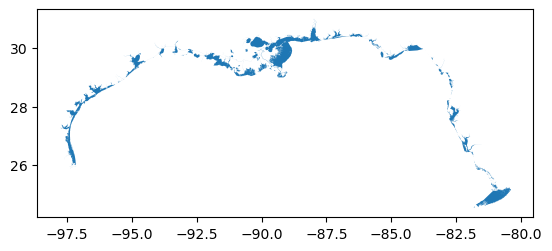

In [4]:
# Plot all the Gulf of Mexico Estuaries (geojson is WGS1984 standard)
wrangle.as_gdf(aoi_url).plot()

### All Gulf of Mexico Estuaries full extent

In [ ]:
# Build query
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = wrangle.get_bounding_box(aoi_url)
# Set low_memory to false for this large querie
query['low_memory'] = False

In [ ]:
query['characteristicName'] = ['Phosphorus',
                                'Temperature, water']

#### Retrieve data

This will be slow

In [ ]:
# Query for results
# Note: large quieries like this can take up a lot of RAM and may give a DtypeWarning,
# set low_memory=False or provide dataTypes for columns to use less memory. 
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

In [ ]:
# Look at initial results (input)
df = res_narrow
df

#### Harmonize data using defaults

In [ ]:
# Harmonize it and look at how it changed (output)
# Note: 'ignore' unit dimensionality errors will warn when they are encountered and replace with NaN
# Note: depending on the Pint version this may cause a UnitStrippedWarning
df_harmonized = harmonize.harmonize_all(df, errors='ignore')
df_harmonized

In [ ]:
set(list(df_harmonized['MonitoringLocationIdentifier'].sort_values()))

In [ ]:
# Get harmonized stations clipped to the Area of Interest
stations_gdf, stations, site_md = location.get_harmonized_stations(query, aoi=aoi_url)

In [ ]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df_harmonized, stations_gdf)
legend_kwds={"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)}
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

In [ ]:
# Map average temperature results at each station
gdf_temperature = visualize.map_measure(df_harmonized, stations_gdf, 'Temperature')
gdf_temperature.plot(column='mean', cmap='OrRd', legend=True)

#### Clean additional columns of data

In [ ]:
df_cleaned = clean.datetime(df_harmonized)  # datetime
df_cleaned = clean.harmonize_depth(df_cleaned)  # Sample depth

### All Gulf of Mexico Estuaries clipped extent (batch)

#### Get data using a Loop over estuaries one at time for batch query

In [5]:
# Area of Interest
aoi_gdf_all = wrangle.as_gdf(aoi_url)

In [6]:
# Query
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
# Set low_memory to false for this large querie
query['low_memory'] = False

In [9]:
results = []

for i in range(0, len(aoi_gdf_all)):
    # Build rest of query
    aoi_gdf = aoi_gdf_all.iloc[i:i+1]
    query['dataProfile'] = 'narrowResult'
    query['bBox'] = wrangle.get_bounding_box(aoi_gdf)
    # Run data query
    res_narrow, md_narrow = wqp.get_results(**query)
    # Run location query
    stations_gdf, stations, site_md = location.get_harmonized_stations(query, aoi=aoi_gdf)
    # Merge
    # NOTE: for fewer station columns: df2_cols=['geometry', 'QA_flag'] 
    combined = wrangle.merge_tables(res_narrow, stations_gdf, merge_cols=['MonitoringLocationIdentifier'])
    # Add geoDataFrame to list
    results.append(combined)

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\dataretrieval\wqp.py:83: DtypeWarning: Columns (9,10,13,17,19,20,21,60,70,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=',')
C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\dataretrieval\wqp.py:83: DtypeWarning: Columns (9,10,13,15,17,19,20,22,31,33,60,64,65,70,71,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=',')
C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\dataretrieval\wqp.py:83: DtypeWarning: Columns (9,10,13,19,20,22,58,60,61,64,65,71,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=',')
C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-p

In [10]:
# Combine list of DataFrames into one geoDataFrame
results_df = pandas.concat(results).drop_duplicates()
gdf = geopandas.GeoDataFrame(results_df, geometry='geometry')

#### Harmonize full dataset

In [18]:
# before debug, save to disk
gdf.to_file(r'C:\Users\jbousqui\Local_GIS\GOM.shp')

C:\Users\jbousqui\AppData\Local\Temp\ipykernel_22932\2688400647.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(r'C:\Users\jbousqui\Local_GIS\GOM.shp')


MemoryError: Unable to allocate 3.30 GiB for an array with shape (46, 9630092) and data type float64

In [19]:
# debug harmonize.harmonize_all(gdf, errors='ignore')
char_vals = list(set(df_out['CharacteristicName']))
for char_val in char_vals:
    print(char_val)
    gdf = harmonize.harmonize_generic(gdf, char_val, errors='ignore')

Chlorophyll a


MemoryError: Unable to allocate 3.30 GiB for an array with shape (46, 9630092) and data type float64

In [11]:
df_harmonized = harmonize.harmonize_all(gdf, errors='ignore')
df_harmonized

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\jbousqui\AppData\Local\Temp\ipykernel_22932\71343121.py", line 1, in <module>
    df_harmonized = harmonize.harmonize_all(gdf, errors='ignore')
  File "C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\harmonize_wq\harmonize.py", line 989, in harmonize_all
  File "C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\harmonize_wq\harmonize.py", line 1022, in harmonize_generic
    """
  File "C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\harmonize_wq\harmonize.py", line 67, in __init__
    self.coerce_measure()
  File "C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\harmonize_wq\harmon

### Work through select estuary

In [ ]:
aoi_gdf_all = wrangle.as_gdf(aoi_url)
aoi_gdf_all

Choose an index for the estuary to retrieve

In [10]:
i = 25

In [11]:
# Print reformated estuary name
estuary_name = aoi_gdf_all.iloc[i]['EDACDA_NM']
out_est_name = str(estuary_name).replace(" ", "_")
out_est_name = out_est_name.replace(".", "")
out_est_name = out_est_name.replace("(", "")
out_est_name = out_est_name.replace(")", "")
print('Estuary Name: "{}" -> "{}"'.format(estuary_name, out_est_name))

Estuary Name: "Galveston Bay" -> "Galveston_Bay"


In [12]:
# Get polygon from polygons
aoi_gdf = aoi_gdf_all.iloc[i:i+1]

<Axes: >

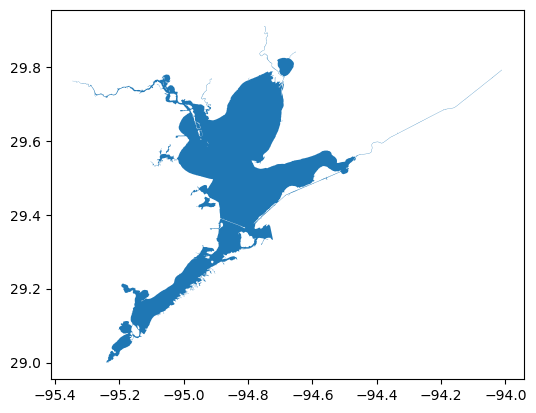

In [13]:
# Map selection
aoi_gdf.plot()

#### Build Query

In [16]:
# Each estuary may be multi-polygon, so the query will be built around the full extent instead of one row
bBox = wrangle.get_bounding_box(aoi_gdf)

In [17]:
# Build query
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = bBox

#### Retrieve Data

In [18]:
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

# dataframe of downloaded results
res_narrow

C:\Users\jbousqui\Local_GIS\Python\Miniforge3\envs\jupyter-harmonize\lib\site-packages\dataretrieval\wqp.py:83: DtypeWarning: Columns (4,5,9,10,15,17,19,22,31,33,34,36,38,61,62,63,70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=',')


,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13702013,2013-04-29,NaN,NaN,TCEQMAIN-15224,STORET-422578803,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13947279,2013-07-11,NaN,NaN,TCEQMAIN-11446,STORET-422881708,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-14329114,2013-10-08,NaN,NaN,TCEQMAIN-15906,STORET-422797456,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13899297,2013-08-01,NaN,NaN,TCEQMAIN-11287,STORET-422829817,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
4,TCEQMAIN,Texas Commission on Environmental Quality,TCEQMAIN-13702703,2013-05-14,NaN,NaN,TCEQMAIN-15216,STORET-422577293,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247935,USGS-TX,USGS Texas Water Science Center,nwistx.01.02302746,2023-07-18,11:45:00,CDT,USGS-08042554,NWIS-125740260,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
247936,USGS-TX,USGS Texas Water Science Center,nwistx.01.02302749,2023-07-18,12:45:00,CDT,USGS-08042546,NWIS-125740338,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
247937,USGS-TX,USGS Texas Water Science Center,nwistx.01.02302749,2023-07-18,12:45:00,CDT,USGS-08042546,NWIS-125740346,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
247938,USGS-TX,USGS Texas Water Science Center,nwistx.01.02302749,2023-07-18,12:45:00,CDT,USGS-08042546,NWIS-125740348,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


<Axes: >

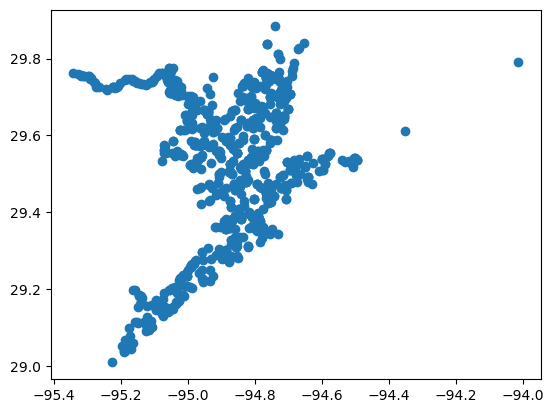

In [19]:
# Get harmonized stations clipped to the Area of Interest
stations_gdf, stations, site_md = location.get_harmonized_stations(query, aoi=aoi_gdf)
stations_gdf.plot()

#### Harmonize characteristic data (all at once)

The harmonize_all() function identifies the characteristics present and uses preset defaults to harmonize each. This function does not has as much flexibility e.g., to keep intermediate columns, produce reports, or convert to non-default units.

In [ ]:
# Harmonize all results
df_harmonized = harmonize.harmonize_all(res_narrow, errors='ignore')
df_harmonized

In [ ]:
# Clean up other columns of data
df_cleaned = clean.datetime(df_harmonized)  # datetime
df_cleaned = clean.harmonize_depth(df_cleaned)  # Sample depth
df_cleaned

#### Map results

In [ ]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df_cleaned, stations_gdf)
legend_kwds = {"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)}
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

In [ ]:
# Map average temperature results at each station
gdf_temperature = visualize.map_measure(df_cleaned, stations_gdf, 'Temperature')
gdf_temperature.plot(column='mean', cmap='OrRd', legend=True)

#### Look through results one parameter at a time

In [ ]:
# Set standard columns to look through results
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag']

Note: if there were no results for a given characteristic a result column will not be generated for that characteristic and there will be a keyError when trying to look at results, e.g., 'KeyError: "['Conductivity'] not in index"' if there are no conductivity results

In [ ]:
# Secchi
df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]

In [ ]:
# Temperature
df.loc[df['CharacteristicName']=='Temperature, water', cols + ['Temperature']]

In [ ]:
# Dissolved Oxygen
df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols + ['DO']]

In [ ]:
# pH
df.loc[df['CharacteristicName']=='pH', cols + ['pH']]

In [ ]:
# Salinity
df.loc[df['CharacteristicName']=='Salinity', cols + ['Salinity']]

In [ ]:
# Nitrogen
df.loc[df['CharacteristicName']=='Nitrogen', cols + ['Nitrogen']]

In [ ]:
# Conductivity
if 'Conductivity' in df.columns:
    df.loc[df['CharacteristicName']=='Conductivity', cols + ['Conductivity']]

In [ ]:
# Chlorophyll A
df.loc[df['CharacteristicName']=='Chlorophyll a', cols + ['Chlorophyll']]

In [ ]:
# Carbon
df.loc[df['CharacteristicName']=='Organic carbon', cols + ['Carbon']]

In [ ]:
# Turbidity
df.loc[df['CharacteristicName']=='Turbidity', cols + ['Turbidity']]

In [ ]:
# Sediment
df.loc[df['CharacteristicName']=='Sediment', cols + ['Sediment']]

In [ ]:
# Phosphorus
df.loc[df['TDP_Phosphorus'].notna(), ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']]

In [ ]:
df.loc[df['TP_Phosphorus'].notna(), ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TP_Phosphorus']]

### Characteristic to Column (long to wide format)

Note: each parameter should be compared against acceptance criteria before these steps as duplicates and bad data can be problematic

In [ ]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

In [ ]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

In [ ]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

In [ ]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [ ]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [ ]:
# Columns still in main table
main_df.columns

In [ ]:
# look at main table results (first 5)
main_df.head()

In [ ]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

In [ ]:
# Map average results at each station
gdf_avg = visualize.map_measure(main_df, stations_gdf, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)